Lambda School Data Science

*Unit 4, Sprint 1, Module 2*

---

# Vector Representations (Prepare)


As we learned yesterday, machines cannot interpret raw text. We need to transform that text into something we/machines can more readily analyze. Yesterday, we did simple counts of counts to summarize the content of Amazon reviews. Today, we'll extend those concepts to talk about vector representations such as Bag of Words (BoW) and word embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow. 

Processing text data to prepare it for machine learning models often means translating the information from documents into a numerical format. Bag-of-Words approaches (sometimes referred to as Frequency-Based word embeddings) accomplish this by "vectorizing" tokenized documents. This is done by representing each document as a row in a DataFrame and creating a column for each unique word in the corpora (group of documents). The presence or lack of a given word in a document is then represented either as a raw count of how many times a given word appears in a document (CountVectorizer) or as that word's TF-IDF score (TfidfVectorizer).

On the python side, we will be focusing on `sklearn` and `spacy` today.  

## Case Study

We're going to pretend we're on the datascience team at the BBC. We want to recommend articles to visitors to on the BBC website based on the article they just read. Our team wants 

**Dataset:**

[D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.](http://mlg.ucd.ie/datasets/bbc.html)
*Please note that the dataset has been sampled down to tech articles only.* 

## Learning Objectives
* <a href="#p1">Part 1</a>: Represent a document as a vector
* <a href="#p2">Part 2</a>: Query Documents by Similarity
* <a href="#p3">Part 3</a>: Apply word embedding models to create document vectors

# Represent a document as a vector (Learn)
<a id="p1"></a>

## Overview

In this section, we are going to create Document Term Matrices (DTM). Each column represents a word. Each row represents a document. The value in each cell can be range of different things. The most traditional: counts of appearances of words, does the word appear at all (binary), and term-frequency inverse-document frequency (TF-IDF). 

**Discussion:** Don't we loose all the context and grammar if we do this? So Why does it work?

## Follow Along

In [2]:
""" Import Statements """

# Classics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_lg")

**Warm Up (_3 Minutes_)**

Extract the tokens from this sentence using Spacy. Text is from [OpenAI](https://openai.com/blog/better-language-models/)

In [3]:
text = """GPT-2 displays a broad set of capabilities, including the ability to generate conditional synthetic text samples of unprecedented quality, where we prime the model with an input and have it generate a lengthy continuation. In addition, GPT-2 outperforms other language models trained on specific domains (like Wikipedia, news, or books) without needing to use these domain-specific training datasets. On language tasks like question answering, reading comprehension, summarization, and translation, GPT-2 begins to learn these tasks from the raw text, using no task-specific training data. While scores on these downstream tasks are far from state-of-the-art, they suggest that the tasks can benefit from unsupervised techniques, given sufficient (unlabeled) data and compute."""

In [4]:
# My attempt
import re
doc = nlp(text)

# YOUR CODE HERE
def tokenize(text):
    filter = re.sub("[^a-zA-Z 0-9]", "", text)
    tokens = filter.lower().split()
    
    return tokens

new_text_tokens = tokenize(text)
print(new_text_tokens)

['gpt2', 'displays', 'a', 'broad', 'set', 'of', 'capabilities', 'including', 'the', 'ability', 'to', 'generate', 'conditional', 'synthetic', 'text', 'samples', 'of', 'unprecedented', 'quality', 'where', 'we', 'prime', 'the', 'model', 'with', 'an', 'input', 'and', 'have', 'it', 'generate', 'a', 'lengthy', 'continuation', 'in', 'addition', 'gpt2', 'outperforms', 'other', 'language', 'models', 'trained', 'on', 'specific', 'domains', 'like', 'wikipedia', 'news', 'or', 'books', 'without', 'needing', 'to', 'use', 'these', 'domainspecific', 'training', 'datasets', 'on', 'language', 'tasks', 'like', 'question', 'answering', 'reading', 'comprehension', 'summarization', 'and', 'translation', 'gpt2', 'begins', 'to', 'learn', 'these', 'tasks', 'from', 'the', 'raw', 'text', 'using', 'no', 'taskspecific', 'training', 'data', 'while', 'scores', 'on', 'these', 'downstream', 'tasks', 'are', 'far', 'from', 'stateoftheart', 'they', 'suggest', 'that', 'the', 'tasks', 'can', 'benefit', 'from', 'unsupervise

In [5]:
# Class attempt
doc = nlp(text)

tokens = [token.lemma_.lower() for token in doc if (token.is_stop != True) and (token.is_punct != True)]
tokens

['gpt-2',
 'display',
 'broad',
 'set',
 'capability',
 'include',
 'ability',
 'generate',
 'conditional',
 'synthetic',
 'text',
 'sample',
 'unprecedented',
 'quality',
 'prime',
 'model',
 'input',
 'generate',
 'lengthy',
 'continuation',
 'addition',
 'gpt-2',
 'outperform',
 'language',
 'model',
 'train',
 'specific',
 'domain',
 'like',
 'wikipedia',
 'news',
 'book',
 'need',
 'use',
 'domain',
 'specific',
 'training',
 'dataset',
 'language',
 'task',
 'like',
 'question',
 'answering',
 'read',
 'comprehension',
 'summarization',
 'translation',
 'gpt-2',
 'begin',
 'learn',
 'task',
 'raw',
 'text',
 'task',
 'specific',
 'training',
 'datum',
 'score',
 'downstream',
 'task',
 'far',
 'state',
 'art',
 'suggest',
 'task',
 'benefit',
 'unsupervised',
 'technique',
 'give',
 'sufficient',
 'unlabeled',
 'datum',
 'compute']

In [6]:
import os 

def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path of .txt files
    
    returns list of strings 
    """
    
    data = []
    
    files = os.listdir(filefolder) # Causes variation across machines
    
    for article in files: 
        
        path = os.path.join(filefolder, article)
                    
        if  path[-3:] == 'txt': # os ~endswith('txt')
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [7]:
data = gather_data('./data')

In [8]:
print(len(data))
print(data[10])

401
b'UK net users leading TV downloads\r\n\r\nBritish TV viewers lead the trend of illegally downloading US shows from the net, according to research.\r\n\r\nNew episodes of 24, Desperate Housewives and Six Feet Under, appear on the web hours after they are shown in the US, said a report. Web tracking company Envisional said 18% of downloaders were from within the UK and that downloads of TV programmes had increased by 150% in the last year. About 70% were using file-sharing program BitTorrent, the firm said. "It\'s now as easy to download a pirate TV show as it is to programme a VCR," said Ben Coppin from Envisional. A typical episode of 24 was downloaded by about 100,000 people globally, said the report, and an estimated 20,000 of those were from within the UK.\r\n\r\nFans of many popular US TV programmes, like 24, usually have to wait weeks or months until the latest series is shown in the UK. But in some cases, said the report, people were able to watch the new episodes in Britain

### CountVectorizer (bag of words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer


# list of text documents
text = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet."," In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma."," This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer
## Can use spacy's stop words (or a union of your added stop words) in the below argument
vect = CountVectorizer(stop_words="english",
                       max_df=0.9,
                       min_df=0.1)

# build vocab
vect.fit(text)

# transform text
dtm = vect.transform(text)


In [10]:
# explore the document-term matrix 
print(dtm.toarray())

[[0 2 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
  0]
 [0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 2
  0]
 [1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0
  1]]


In [11]:
# print out raw text for comparison with  indexing
vect.vocabulary_

{'created': 2,
 'new': 23,
 'dataset': 5,
 'emphasizes': 10,
 'diversity': 7,
 'content': 1,
 'scraping': 31,
 'internet': 18,
 'order': 24,
 'preserve': 27,
 'document': 8,
 'quality': 28,
 'used': 35,
 'pages': 26,
 'curated': 3,
 'filtered': 11,
 'humans': 15,
 'specifically': 33,
 'outbound': 25,
 'links': 22,
 'reddit': 30,
 'received': 29,
 'karma': 19,
 'thought': 34,
 'heuristic': 13,
 'indicator': 16,
 'users': 36,
 'link': 21,
 'interesting': 17,
 'educational': 9,
 'funny': 12,
 'leading': 20,
 'higher': 14,
 'data': 4,
 'similar': 32,
 'datasets': 6,
 'commoncrawl': 0}

In [12]:
vect.get_feature_names()

['commoncrawl',
 'content',
 'created',
 'curated',
 'data',
 'dataset',
 'datasets',
 'diversity',
 'document',
 'educational',
 'emphasizes',
 'filtered',
 'funny',
 'heuristic',
 'higher',
 'humans',
 'indicator',
 'interesting',
 'internet',
 'karma',
 'leading',
 'link',
 'links',
 'new',
 'order',
 'outbound',
 'pages',
 'preserve',
 'quality',
 'received',
 'reddit',
 'scraping',
 'similar',
 'specifically',
 'thought',
 'used',
 'users']

**Three Minute Challenge:** 
* Apply CountVectorizer to our BBC Data
* Store results in a dataframe called `dtm`
* Extra Challenge - Try to Customize CountVectorizer with Spacy Processing

In [13]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
# BBC articles in `data` variable

from sklearn.feature_extraction.text import CountVectorizer

#Learn our Vocab
vect = CountVectorizer(stop_words="english",
                       max_df=0.9,
                       min_df=0.1)

vect.fit(data)

# Get sparse dtm (i.e. transform the data)
dtm2 = vect.transform(data)

In [14]:
# list of document length measured by num of tokens in document
doc_len = [len(doc) for doc in data]

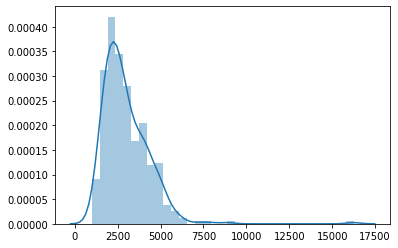

In [15]:
import seaborn as sns

sns.distplot(doc_len);

### TfidfVectorizer

## Term Frequency - Inverse Document Frequency (TF-IDF)

<center><img src="https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336" width="300"></center>

Term Frequency: Percentage of words in document for each word

Document Frequency: A penalty for the word existing in a high number of documents.

The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents which will allow for each document's most different topics to rise to the top.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
# n-grams - combination of tokens (multiple words) as one token for a new meaning ex. new, year
vect = TfidfVectorizer(ngram_range=(1, 2))

# Create a vocabulary and get word counts per document
dtm3 = vect.fit_transform(data)

# Print word counts

# Get feature names to use as dataframe column headers
# vect.get_feature_names()
# View Feature Matrix as DataFrame


In [18]:
# Review dimensionality
dtm3

<401x100516 sparse matrix of type '<class 'numpy.float64'>'
	with 279728 stored elements in Compressed Sparse Row format>

In [21]:
def tokenize(document):
    """
    Takes a doc and returns a list of tokens in the form of lemmas.
    Stop words and punctuation are filtered out. 
    """
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [23]:
# Tunning Parameters

# Instantiate vectorizer object
vect = TfidfVectorizer(ngram_range=(1, 1), tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm4 = vect.fit_transform(data)

In [25]:
dtm4

<401x9327 sparse matrix of type '<class 'numpy.float64'>'
	with 67396 stored elements in Compressed Sparse Row format>

In [27]:
# Get feature names to use as dataframe column headers
columns = vect.get_feature_names()
# View Feature Matrix as DataFrame
df = pd.DataFrame(data=dtm4.todense(), columns=columns)
df.head()

,,$,+,-PRON-,-top,.22,.aero,.biz,.com,.fr,...,zero,zhang,zip,zodiac,zombie,zone,zonealarm,zoom,zurich,£
0,0.056296,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.045977,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.084311,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.062306,0.102728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030307
4,0.057437,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019956


## Challenge

During this module's project assignment, you will transform data science job listings to vector representations for analysis downstream. 

# Query Documents by Similarity (Learn)
<a id="p2"></a>

## Overview

Have you ever considered how a search bar works? You may just think that search bars simply match your input text againist the documents. While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply n-dimensional distance to measure similarity, and query for input and output. 

## Follow Along

### Cosine Similarity (Brute Force)

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Distance of TF-IDF Vectors
vect = TfidfVectorizer(ngram_range=(1, 1))
dtm = vect.fit_transform(data)

dist_matrix = cosine_similarity(dtm)

# Turn it into a DataFrame
df = pd.DataFrame(data=dist_matrix)

# Our Similarity Matrix is ? size 

In [45]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,1.000000,0.150932,0.090251,0.185854,0.217376,0.224663,0.120794,0.163533,0.255286,0.135597,...,0.187808,0.127044,0.206361,0.259127,0.197492,0.120157,0.148488,0.251379,0.136347,0.227436
1,0.150932,1.000000,0.084585,0.193445,0.188821,0.194653,0.099155,0.133373,0.211864,0.134058,...,0.203316,0.154255,0.188465,0.220718,0.169580,0.144317,0.161796,0.212452,0.130640,0.221551
2,0.090251,0.084585,1.000000,0.123824,0.147151,0.126350,0.258467,0.277595,0.140451,0.171439,...,0.110373,0.109932,0.187616,0.177860,0.129173,0.131030,0.182933,0.169792,0.122300,0.150550
3,0.185854,0.193445,0.123824,1.000000,0.260081,0.255655,0.148800,0.175840,0.340790,0.191235,...,0.220227,0.154898,0.286967,0.327107,0.270802,0.164575,0.167178,0.288369,0.180676,0.310806
4,0.217376,0.188821,0.147151,0.260081,1.000000,0.283861,0.154415,0.203583,0.317288,0.201106,...,0.277921,0.203136,0.313108,0.397688,0.346150,0.224186,0.204748,0.335341,0.181974,0.352450


In [46]:
# Each row is the similarity of one document to all other documents (including itself)
doc_i = 0
df[doc_i][:5]

# Grab the row and pick off the indicies of the most/least similar docs
df[df[doc_i] < 1][0].sort_values(ascending=False)[:5]

332    0.329820
36     0.297569
378    0.261452
394    0.259127
8      0.255286
Name: 0, dtype: float64

In [47]:
# reference doc
data[0]

b'Ink helps drive democracy in Asia\r\n\r\nThe Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country\'s elections as part of a drive to prevent multiple voting.\r\n\r\nThis new technology is causing both worries and guarded optimism among different sectors of the population. In an effort to live up to its reputation in the 1990s as "an island of democracy", the Kyrgyz President, Askar Akaev, pushed through the law requiring the use of ink during the upcoming Parliamentary and Presidential elections. The US government agreed to fund all expenses associated with this decision.\r\n\r\nThe Kyrgyz Republic is seen by many experts as backsliding from the high point it reached in the mid-1990s with a hastily pushed through referendum in 2003, reducing the legislative branch to one chamber with 75 deputies. The use of ink is only one part of a general effort to show commitment towards more open elections - the G

In [48]:
# most similar
data[2]

b"Microsoft seeking spyware trojan\r\n\r\nMicrosoft is investigating a trojan program that attempts to switch off the firm's anti-spyware software.\r\n\r\nThe spyware tool was only released by Microsoft in the last few weeks and has been downloaded by six million people. Stephen Toulouse, a security manager at Microsoft, said the malicious program was called Bankash-A Trojan and was being sent as an e-mail attachment. Microsoft said it did not believe the program was widespread and recommended users to use an anti-virus program. The program attempts to disable or delete Microsoft's anti-spyware tool and suppress warning messages given to users.\r\n\r\nIt may also try to steal online banking passwords or other personal information by tracking users' keystrokes.\r\n\r\nMicrosoft said in a statement it is investigating what it called a criminal attack on its software. Earlier this week, Microsoft said it would buy anti-virus software maker Sybari Software to improve its security in its Wi

In [49]:
# least similar
data[8]

b'Apple laptop is \'greatest gadget\'\r\n\r\nThe Apple Powerbook 100 has been chosen as the greatest gadget of all time, by US magazine Mobile PC.\r\n\r\nThe 1991 laptop was chosen because it was one of the first "lightweight" portable computers and helped define the layout of all future notebook PCs. The magazine has compiled an all-time top 100 list of gadgets, which includes the Sony Walkman at number three and the 1956 Zenith remote control at two. Gadgets needed moving parts and/or electronics to warrant inclusion. The magazine specified that gadgets also needed to be a "self-contained apparatus that can be used on its own, not a subset of another device".\r\n\r\n"In general we included only items that were potentially mobile," said the magazine.\r\n\r\n"In the end, we tried to get to the heart of what really makes a gadget a gadget," it concluded. The oldest "gadget" in the top 100 is the abacus, which the magazine dates at 190 A.D., and put in 60th place. Other pre-electronic ga

### NearestNeighbor (K-NN) 
![](https://miro.medium.com/max/753/0*jqxx3-dJqFjXD6FA)


Nearest Neighbor models are distance based algorithms. They store your training set in memory. 

When you want to find the nearest neighbors for a point in your test set, then simply calculate the distance of the nearest k points. 

So instead of calculating the every single possible distance between all points (i.e. **Brute Force** ) , NN models only calculate the nearest k distances. 

In [50]:
# fixes cosine scalability issues
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(algorithm="kd_tree",
                      n_neighbors=10)
nn.fit(dtm)

c:\users\dakot\.virtualenvs\ds-unit-4-sprint-1-nlp-odz-vccn\lib\site-packages\sklearn\neighbors\_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [51]:
# sample a doc from dtm to use as our query point 
doc_index = 0
doc_vector = [dtm.iloc[doc_index].values]

# Query Using kneighbors 
dist, ind = nn.kneighbors(doc_vector)
print(dist, ind)

AttributeError: iloc not found

In [52]:
rndm_tech_article = [ """
Blockchain technology encompasses so much more than just cryptocurrencies these days. And while these currencies are by far blockchain’s most famous use case, the potential for blockchain far, far exceeds a straightforward transfer of value.
The gaming industry, for example, has always been fairly controversial due to a range of issues. Many players feel particularly worried about the protection of their data, fraudulent activities, high fees, and most of all, unfair and hidden odds.
In these cases, P2P doesn’t just mean peer-to-peer; it means player-to-player. As with the other P2P industries that blockchain is disrupting, such as FinTech, there are already plenty of ways in which blockchain technology is being applied to resolve these issues and many more of the challenges faced by the gaming industry. Here are just a few.
Reducing fraud
The gaming industry suffers a lot from online fraud. One of the main advantages of blockchain technology is that it enables highly secure data encryption. What’s more, all of it is entirely accessible and transparent to the player. In other words, blockchain is a for game changer for venues such as online casinos, lotteries, and virtually anything which relies on random number generation.
On top of this, hackers will have particularly hard time, if it is even possible, to destroy a decentralized blockchain network, making sure gamer data stays safe. This is an inherent feature of distributed ledger technology whereby nodes in the ledger maintain the distributed databases in a shared manner, and each node has the complete information in the entire database.
"""]

# Fit NN for similarity of random doc to BBC dataset

# Query Using kneighbors 

# Inspect Most relevant result

## Challenge

In the module project assignment, you will apply one of these search techniques to retrieve documents related to a query document. 

# Apply word embedding models to create document vectors (Learn)
<a id="p3"></a>

## Overview
### BoW discards textual context

One of the limitations of Bag-of-Words approaches is that any information about the textual context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

### Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

### Word2Vec Intuition
### The Distribution Hypothesis

In order to understand how Word2Vec preserves textual context we have to understand what's called the Distribution Hypothesis (Reference: Distribution Hypothesis Theory  -https://en.wikipedia.org/wiki/Distributional_semantics. The Distribution Hypothesis operates under the assumption that words that have similar contexts will have similar meanings. Practically speaking, this means that if two words are found to have similar words both to the right and to the left of them throughout the corpora then those words have the same context and are assumed to have the same meaning. 

> "You shall know a word by the company it keeps" - John Firth

This means that we let the usage of a word define its meaning and its "similarity" to other words. In the following example, which words would you say have a similar meaning? 

**Sentence 1**: Traffic was light today

**Sentence 2**: Traffic was heavy yesterday

**Sentence 3**: Prediction is that traffic will be smooth-flowing tomorrow since it is a national holiday

What words in the above sentences seem to have a similar meaning if all you knew about them was the context in which they appeared above? 

Lets take a look at how this might work in action, the following example is simplified, but will give you an idea of the intuition for how this works.

#### Corpora:

1) "It was the sunniest of days."

2) "It was the raniest of days."

#### Vocabulary:

{"it": 1, "was": 2, "the": 3, "of": 4, "days": 5, "sunniest": 6, "raniest": 7}

### Vectorization

|       doc   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | it_the | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|--------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0      | 0           | 0            | 0      |
| was      | 0         | 1      | 0            | 0      | 0             | 0     | 0        | 1      | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 0      | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0      | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0      | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |

Each column vector represents the word's context -in this case defined by the words to the left and right of the center word. How far we look to the left and right of a given word is referred to as our "window of context." Each row vector represents the the different usages of a given word. Word2Vec can consider a larger context than only words that are immediately to the left and right of a given word, but we're going to keep our window of context small for this example. What's most important is that this vectorization has translated our documents from a text representation to a numeric one in a way that preserves information about the underlying context. 

We can see that words that have a similar context will have similar row-vector representations, but before looking that more in-depth, lets simplify our vectorization slightly. You'll notice that we're repeating the column-vector "it_the" twice. Lets combine those into a single vector by adding them element-wise. 

|       *   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0           | 0            | 0      |
| was      | 0         | 2      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |

Now, can you spot which words have a similar row-vector representation? Hint: Look for values that are repeated in a given column. Each column represents the context that word was found in. If there are multiple words that share a context then those words are understood to have a closer meaning with each other than with other words in the text.

Lets look specifically at the words sunniest and raniest. You'll notice that these two words have exactly the same 10-dimensional vector representation. Based on this very small corpora of text we would conclude that these two words have the same meaning because they share the same usage. Is this a good assumption? Well, they are both referring to the weather outside so that's better than nothing. You could imagine that as our corpora grows larger we will be exposed a greater number of contexts and the Distribution Hypothesis assumption will improve. 

### Word2Vec Variants

#### Skip-Gram

The Skip-Gram method predicts the neighbors’ of a word given a center word. In the skip-gram model, we take a center word and a window of context (neighbors) words to train the model and then predict context words out to some window size for each center word.

This notion of “context” or “neighboring” words is best described by considering a center word and a window of words around it. 

For example, if we consider the sentence **“The speedy Porsche drove past the elegant Rolls-Royce”** and a window size of 2, we’d have the following pairs for the skip-gram model:

**Text:**
**The**	speedy	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (the, speedy), (the, Porsche)

**Text:**
The	**speedy**	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (speedy, the), (speedy, Porsche), (speedy, drove)

**Text:**
The	speedy	**Porsche**	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (Porsche, the), (Porsche, speedy), (Porsche, drove), (Porsche, past)

**Text:**
The	speedy	Porsche	**drove**	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (drove, speedy), (drove, Porsche), (drove, past), (drove, the)

The **Skip-gram model** is going to output a probability distribution i.e. the probability of a word appearing in context given a center word and we are going to select the vector representation that maximizes the probability.

With CountVectorizer and TF-IDF the best we could do for context was to look at common bi-grams and tri-grams (n-grams). Well, skip-grams go far beyond that and give our model much stronger contextual information.

![alt text](https://www.dropbox.com/s/c7mwy6dk9k99bgh/Image%202%20-%20SkipGrams.jpg?raw=1)

## Continuous Bag of Words

This model takes thes opposite approach from the skip-gram model in that it tries to predict a center word based on the neighboring words. In the case of the CBOW model, we input the context words within the window (such as “the”, “Proshe”, “drove”) and aim to predict the target or center word “speedy” (the input to the prediction pipeline is reversed as compared to the SkipGram model).

A graphical depiction of the input to output prediction pipeline for both variants of the Word2vec model is attached. The graphical depiction will help crystallize the difference between SkipGrams and Continuous Bag of Words.

![alt text](https://www.dropbox.com/s/k3ddmbtd52wq2li/Image%203%20-%20CBOW%20Model.jpg?raw=1)

## Notable Differences between Word Embedding methods:

1) W2V focuses less document topic-modeling. You'll notice that the vectorizations don't really retain much information about the original document that the information came from. At least not in our examples.

2) W2V can result in really large and complex vectorizations. In fact, you need Deep Neural Networks to train your Word2Vec models from scratch, but we can use helpful pretrained embeddings (thank you Google) to do really cool things!

*^ All that noise....AND Spacy has pretrained a Word2Vec model you can just use? WTF JC?*

Let's take a look at how to do it. 

In [ ]:
# Process a text
nlp = spacy.load('en_core_web_lg')

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
doc1 = nlp("It's a warm summer day")
doc2 = nlp("I saw a dog today.")

# since w2v only has word vectors in it's embeddings
# doc vectors are created by averaging the word vectors in that doc

# we can calculate the similarity between docs now! 

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['machine learning', 
         'artificial intelligence', 
         'data', 'science', 
         'concrete', 'wood', 
         'marble', 'design',
         'color', 'font']


# intialise pca model and tell it to project data down onto 2 dimensions

# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.

# let's look at our new 2D word vectors



# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# create a nice big plot 
plt.figure(figsize=(20,15))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot|
plt.show()

## Challenge

You will extract word embeddings from documents using Spacy's pre-trained model in the upcoming module project. 

# Review
For your module project assignment you will create vector representations of indeed.com Data Science job listings. You will then estimate a similarity model to perform searches for job descriptions. Get started with your [module project here](./LS_DS_412_Vector_Representations_Assignment.ipynb)

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf